# Bag Actuation vs. Volume Mapping (#69)

This is about mapping flow and actuation.

In [1]:
import sys, io

In [2]:
import numpy as np

In [425]:
import matplotlib.figure

In [2]:
from IPython.core.display import Image, display, HTML

%matplotlib inline

We have measured pressure / weight:

In [6]:
actuation_volume_samples = {
}

In [236]:
squeezer_data = """
0	0
1	45
1.5	80
2	125
2.5	180
3	240
3.5	320
4	400
4.5	480
5	590
5.5	700
""".strip().splitlines()
xys = list()
for line in squeezer_data:
    a, b = line.split("\t")
    a = float(a) / 5.5
    b = float(b) / 1000
    xys.append((a, b))

actuation_volume_samples.update(
 Squeezer=dict(xys),
)


In [234]:
actuation_volume_samples_inter = dict()

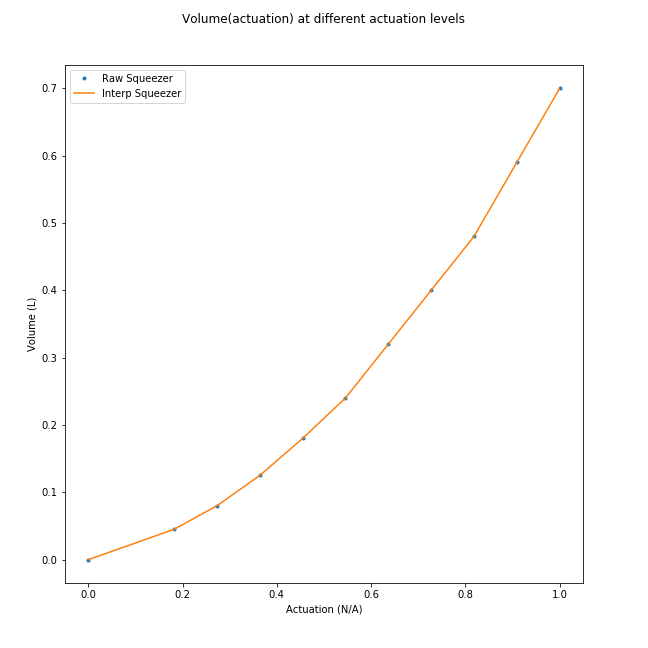

In [426]:
def fig_actvol():
    subpcfg = matplotlib.figure.SubplotParams(
     left  =0.10,
     bottom=0.10,
     right =0.90,
     top   =0.90,
     wspace=0.00,
     hspace=0.00,
    )
    figure = matplotlib.figure.Figure(
     facecolor='white',
     edgecolor='white',
     subplotpars=subpcfg,
     figsize=(9,9),
    )
    
    axes = figure.add_subplot(1, 1, 1)
    axes.set_xlabel(("Actuation (N/A)"))
    axes.set_ylabel(("Volume (L)"))
    
    for scheme_name in actuation_volume_samples.keys():
        xs = list()
        ys = list()
        for p, w in sorted(actuation_volume_samples[scheme_name].items()):
            xs.append(p)
            ys.append(w)

        ys_inter = scipy.interpolate.interp1d(xs, ys, fill_value="extrapolate")
        actuation_volume_samples_inter[scheme_name] = ys_inter

        axes.plot(xs, ys, ".", label=f"Raw {scheme_name}")
        axes.plot(xs, ys_inter(xs), "-", label=f"Interp {scheme_name}")
    
    axes.legend()
    figure.suptitle(f"Volume(actuation) at different actuation levels")
    
    return figure

fig = fig_actvol()
canvasbase = matplotlib.backend_bases.FigureCanvasBase(fig)
figure_canvas = canvasbase._get_output_canvas("png")
f = io.BytesIO()
figure_canvas.print_png(f)
display(Image(data=f.getvalue(), format="png", embed=True))

In [244]:
import scipy.interpolate

In [245]:
import scipy.signal

In [246]:
act2flow = dict()

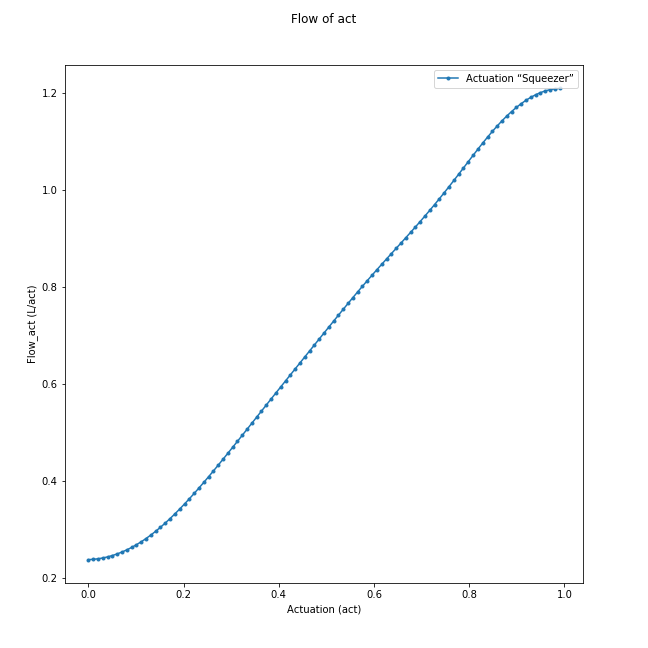

In [427]:
def fig_actflow():
    subpcfg = matplotlib.figure.SubplotParams(
     left  =0.10,
     bottom=0.10,
     right =0.90,
     top   =0.90,
     wspace=0.00,
     hspace=0.00,
    )
    figure = matplotlib.figure.Figure(
     facecolor='white',
     edgecolor='white',
     subplotpars=subpcfg,
     figsize=(9,9),
    )
    
    axes = figure.add_subplot(1, 1, 1)
    axes.set_xlabel(("Actuation (act)"))
    axes.set_ylabel(("Flow_act (L/act)"))
    
    for scheme_name in actuation_volume_samples.keys():
        ys_int = actuation_volume_samples_inter[scheme_name]
        nb_pts = 100
        xs_ = np.linspace(0, 1, nb_pts)
        ys_ = ys_int(xs_)

        if 1:
            b, a = scipy.signal.ellip(2, 0.01, 120.0, 0.01, 'low')
            ys_ = scipy.signal.filtfilt(b, a, ys_, padlen=99)
                
        dys = (ys_[1:] - ys_[:-1]) * nb_pts
        dys_xs = xs_[:-1]
        axes.plot(dys_xs, dys, ".-", label=f"Actuation “{scheme_name}”")
        
        act2flow[scheme_name] = scipy.interpolate.interp1d(dys_xs, dys, fill_value="extrapolate")
    
    axes.legend()
    
    figure.suptitle(f"Flow of act")
    
    return figure

fig = fig_actflow()
canvasbase = matplotlib.backend_bases.FigureCanvasBase(fig)
figure_canvas = canvasbase._get_output_canvas("png")
f = io.BytesIO()
figure_canvas.print_png(f)
display(Image(data=f.getvalue(), format="png", embed=True))

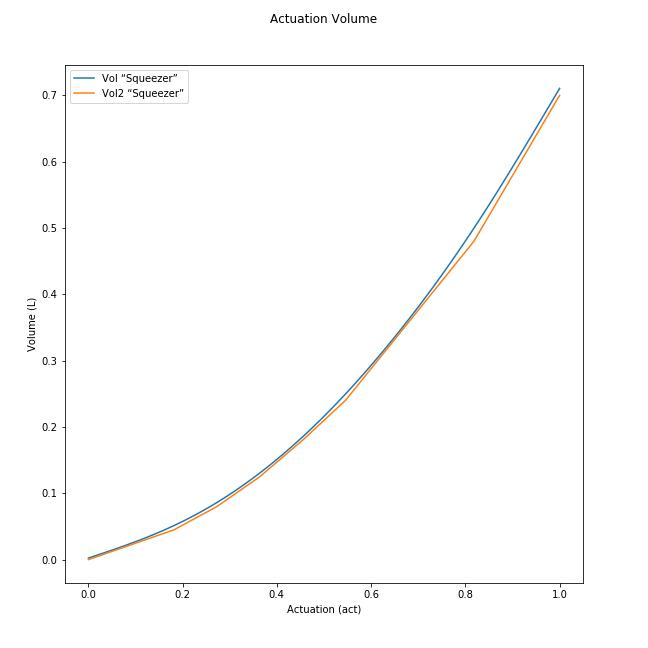

In [428]:
def fig_actvol():
    subpcfg = matplotlib.figure.SubplotParams(
     left  =0.10,
     bottom=0.10,
     right =0.90,
     top   =0.90,
     wspace=0.00,
     hspace=0.00,
    )
    figure = matplotlib.figure.Figure(
     facecolor='white',
     edgecolor='white',
     subplotpars=subpcfg,
     figsize=(9,9),
    )
    
    axes = figure.add_subplot(1, 1, 1)
    axes.set_xlabel(("Actuation (act)"))
    axes.set_ylabel(("Volume (L)"))
    
    nb_pts = 100
    flows = dict()

    for scheme_name in actuation_volume_samples.keys():
        act2flo = act2flow[scheme_name]
        xs = np.linspace(0, 1, nb_pts)
        ys = act2flo(xs)
        ys = np.cumsum(ys) / nb_pts
        axes.plot(xs, ys, "-", label=f"Vol “{scheme_name}”")
        
        act2vol = actuation_volume_samples_inter[scheme_name]
        ys = act2vol(xs)
        axes.plot(xs, ys, "-", label=f"Vol2 “{scheme_name}”")
    
    axes.legend()
        
    figure.suptitle(f"Actuation Volume")
    
    return figure

fig = fig_actvol()
canvasbase = matplotlib.backend_bases.FigureCanvasBase(fig)
figure_canvas = canvasbase._get_output_canvas("png")
f = io.BytesIO()
figure_canvas.print_png(f)
display(Image(data=f.getvalue(), format="png", embed=True))

What actuation profile do we need in order to achieve constant flow?

In [409]:
corrections = dict()

No correction

In [410]:
for scheme_name in actuation_volume_samples.keys():
    xs = np.linspace(0, 1, 10)
    corrections[scheme_name+"-uniform"] = scipy.interpolate.interp1d(xs, xs, fill_value="extrapolate")

Reciprocal of volume curve

In [411]:
for scheme_name in actuation_volume_samples.keys():
    ys_int = actuation_volume_samples_inter[scheme_name]
    v0 = ys_int(0)
    v1 = ys_int(1)
    nb_xs = 1000
    xs = np.linspace(0, 1, nb_xs)
    ys = (ys_int(xs) - v0) / (v1 - v0)
    corrections[scheme_name + "-constant-flow"] = scipy.interpolate.interp1d(ys, xs, fill_value="extrapolate")

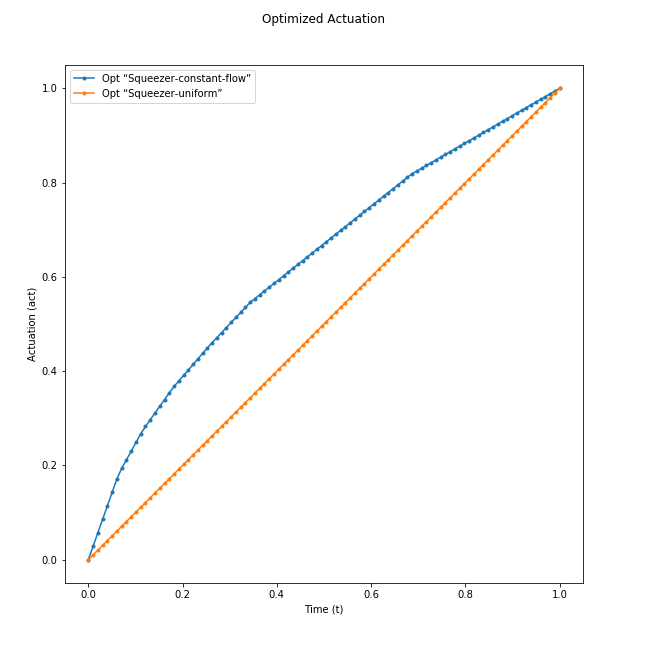

In [429]:
def fig_actopt():
    subpcfg = matplotlib.figure.SubplotParams(
     left  =0.10,
     bottom=0.10,
     right =0.90,
     top   =0.90,
     wspace=0.00,
     hspace=0.00,
    )
    figure = matplotlib.figure.Figure(
     facecolor='white',
     edgecolor='white',
     subplotpars=subpcfg,
     figsize=(9,9),
    )
    
    axes = figure.add_subplot(1, 1, 1)
    axes.set_xlabel(("Time (t)"))
    axes.set_ylabel(("Actuation (act)"))
    
    nb_pts = 100
    ts = np.linspace(0, 1, 100)

    for scheme_name in sorted(corrections.keys()):
        xs = corrections[scheme_name](ts)
        axes.plot(ts, xs, ".-", label=f"Opt “{scheme_name}”")
    
    axes.legend()

    figure.suptitle(f"Optimized Actuation")
    
    return figure

fig = fig_actopt()
canvasbase = matplotlib.backend_bases.FigureCanvasBase(fig)
figure_canvas = canvasbase._get_output_canvas("png")
f = io.BytesIO()
figure_canvas.print_png(f)
display(Image(data=f.getvalue(), format="png", embed=True))

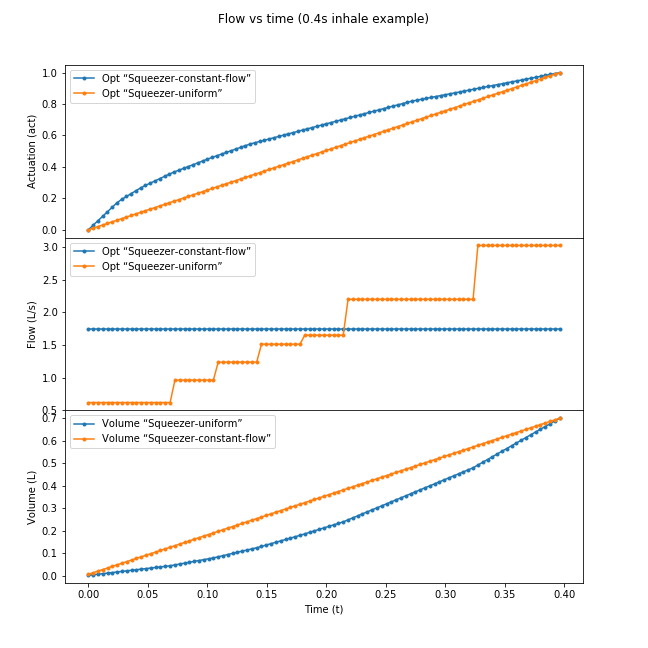

In [430]:
def fig_actvol():
    subpcfg = matplotlib.figure.SubplotParams(
     left  =0.10,
     bottom=0.10,
     right =0.90,
     top   =0.90,
     wspace=0.00,
     hspace=0.00,
    )
    figure = matplotlib.figure.Figure(
     facecolor='white',
     edgecolor='white',
     subplotpars=subpcfg,
     figsize=(9,9),
    )
    
    axes = figure.add_subplot(3, 1, 1)
    axes.set_xlabel(("Time (t)"))
    axes.set_ylabel(("Actuation (act)"))
    
    nb_pts = 100
    ts = np.linspace(0, 0.4, 100)
    dt = ts[1] - ts[0]
    flows = dict()

    for scheme_name in actuation_volume_samples.keys():     
        xs = np.linspace(0, 1, nb_pts)
        for correction, lut in sorted(corrections.items()):
            if not correction.startswith(scheme_name):
                continue
            xs_ = lut(xs)
            axes.plot(ts, xs_, ".-", label=f"Opt “{correction}”")
    
    axes.legend()
    
    axes = figure.add_subplot(3, 1, 2)
    axes.set_xlabel(("Time (t)"))
    axes.set_ylabel(("Flow (L/s)"))
    
    nb_pts = 100
    ts = np.linspace(0, 0.4, 100)
    dt = ts[1] - ts[0]
    flows = dict()

    for scheme_name in actuation_volume_samples.keys():     

        xs = np.linspace(0, 1, nb_pts)
        
        for correction, lut in sorted(corrections.items()):
            if not correction.startswith(scheme_name):
                continue
            xs_ = lut(xs)
            
            vs = actuation_volume_samples_inter[scheme_name](xs_)
            
            fs = (vs[1:]-vs[:-1])/dt
            #act2flo = act2flow[scheme_name]
            #fs = act2flo(xs_)
            
            flows[correction] = fs
            axes.plot(ts[:-1], fs, ".-", label=f"Opt “{correction}”")
    
    axes.legend()

    # Volume
    
    axes = figure.add_subplot(3, 1, 3)
    axes.set_xlabel(("Time (t)"))
    axes.set_ylabel(("Volume (L)"))
    
    for correction in corrections.keys():
        fs = flows[correction]
        vs = np.cumsum(fs) * dt
        
        axes.plot(ts[:-1], vs, ".-", label=f"Volume “{correction}”")
    
    axes.legend()
    
    figure.suptitle(f"Flow vs time (0.4s inhale example)")
    
    return figure

fig = fig_actvol()
canvasbase = matplotlib.backend_bases.FigureCanvasBase(fig)
figure_canvas = canvasbase._get_output_canvas("png")
f = io.BytesIO()
figure_canvas.print_png(f)
display(Image(data=f.getvalue(), format="png", embed=True))

Now what is the required speed?

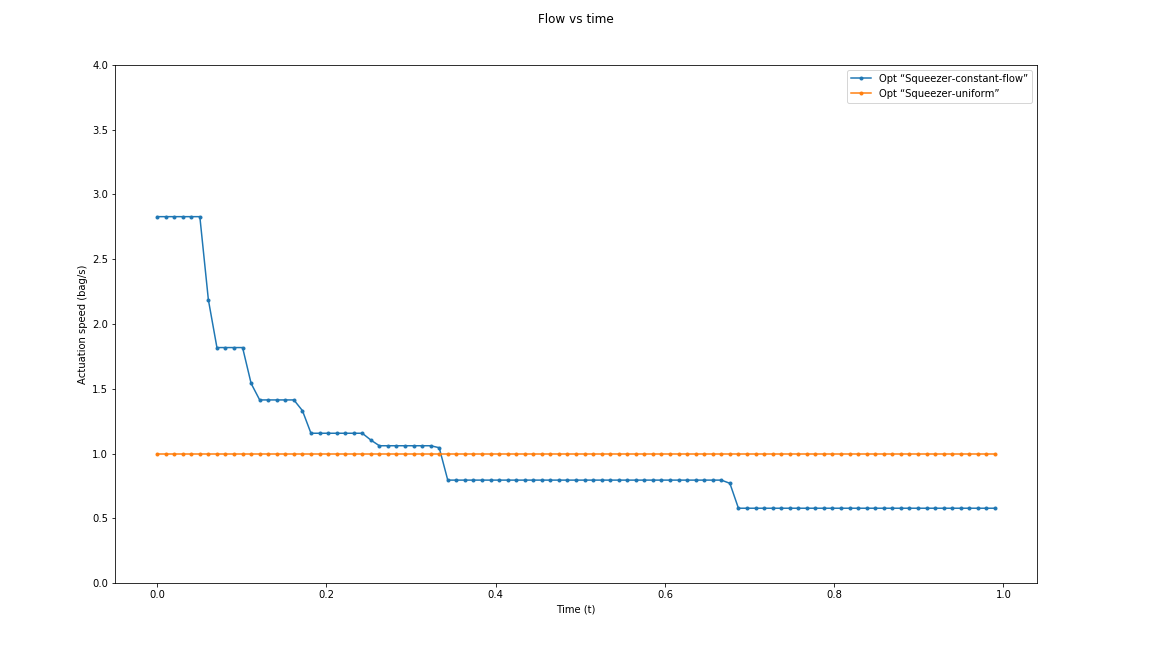

In [431]:
def fig_actspeed():
    subpcfg = matplotlib.figure.SubplotParams(
     left  =0.10,
     bottom=0.10,
     right =0.90,
     top   =0.90,
     wspace=0.00,
     hspace=0.00,
    )
    figure = matplotlib.figure.Figure(
     facecolor='white',
     edgecolor='white',
     subplotpars=subpcfg,
     figsize=(16,9),
    )
    
    axes = figure.add_subplot(1, 1, 1)
    axes.set_xlabel(("Time (t)"))
    axes.set_ylabel(("Actuation speed (bag/s)"))
    axes.set_ylim((0, 4))
    
    nb_pts = 100
    ts = np.linspace(0, 1.0, nb_pts)
    dt = ts[1] - ts[0]
    flows = dict()

    for scheme_name in actuation_volume_samples.keys():     
        xs = np.linspace(0, 1, nb_pts)
        for correction, lut in sorted(corrections.items()):
            if not correction.startswith(scheme_name):
                continue
            xs_ = lut(xs)
            dx = np.ediff1d(xs_)
            vs = dx / dt
            vs = vs
            #print(list(ts))
            #print(list(vs))
            axes.plot(ts[:-1], vs, ".-", label=f"Opt “{correction}”")
    
    axes.legend()
    
    figure.suptitle(f"Flow vs time")
    
    return figure

fig = fig_actspeed()
canvasbase = matplotlib.backend_bases.FigureCanvasBase(fig)
figure_canvas = canvasbase._get_output_canvas("png")
f = io.BytesIO()
figure_canvas.print_png(f)
display(Image(data=f.getvalue(), format="png", embed=True))